In [4]:
!pip install rarfile

In [5]:
!pip install nnfs

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from urllib import request
import gzip
import pickle
import os

In [18]:
import rarfile
import os
from PIL import Image

# Extract the RAR file
rar_path = '/content/our_dataset.rar'  # Replace with your actual RAR file path
extract_path = 'extracted_dataset'
# Create extraction directory if it doesn't exist
if not os.path.exists(extract_path):
    os.makedirs(extract_path)
# Extract the RAR file
with rarfile.RarFile(rar_path) as rf:
    rf.extractall(extract_path)
# List the extracted files
extracted_files = os.listdir(extract_path)
print(f"Extracted {len(extracted_files)} files")

Extracted 1 files


In [8]:
import numpy as np
import matplotlib.pyplot as plt
from nnfs.datasets import spiral_data

# Initialize data
X, Y = spiral_data(100, 3)  # 100 points per class, 3 classes

class Layer_Dense:
    def __init__(self, n_inputs, n_neurons):
        self.weights = 0.10 * np.random.randn(n_inputs, n_neurons)
        self.biases = np.zeros((1, n_neurons))

    def forward(self, inputs):
        self.inputs = inputs
        self.output = np.dot(inputs, self.weights) + self.biases

    def backward(self, dvalues):
        # Gradients with respect to weights
        self.dweights = np.dot(self.inputs.T, dvalues)
        # Gradients with respect to biases
        self.dbiases = np.sum(dvalues, axis=0, keepdims=True)
        # Gradients with respect to inputs (for the layer below)
        self.dinputs = np.dot(dvalues, self.weights.T)

class Activation_ReLU:
    def forward(self, inputs):
        self.inputs = inputs
        self.output = np.maximum(0, inputs)

    def backward(self, dvalues):
        self.dinputs = dvalues.copy()
        self.dinputs[self.inputs <= 0] = 0

class Activation_Softmax:
    def forward(self, inputs):
        exp_values = np.exp(inputs - np.max(inputs, axis=1, keepdims=True))
        probabilities = exp_values / np.sum(exp_values, axis=1, keepdims=True)
        self.output = probabilities

    def backward(self, dvalues):
        self.dinputs = np.zeros_like(dvalues)
        # For each sample, compute Jacobian matrix
        for index, (single_output, single_dvalues) in enumerate(zip(self.output, dvalues)):
            # Flatten
            single_output = single_output.reshape(-1, 1)
            # Jacobian matrix of softmax
            jacobian_matrix = np.diagflat(single_output) - np.dot(single_output, single_output.T)
            # Calc gradient + store
            self.dinputs[index] = np.dot(jacobian_matrix, single_dvalues)

class Loss:
    def calculate(self, output, y):
        sample_losses = self.forward(output, y)
        data_loss = np.mean(sample_losses)
        return data_loss

class Loss_crossentropy(Loss):
    def forward(self, y_predicted, y_true):
        samples = len(y_predicted)
        y_pred_clipped = np.clip(y_predicted, 1e-7, 1-1e-7)

        if len(y_true.shape) == 1:  # Sparse labels
            correct_confidences = y_pred_clipped[range(samples), y_true]
        elif len(y_true.shape) == 2:  # One-hot encoded
            correct_confidences = np.sum(y_pred_clipped*y_true, axis=1)

        neg_log_likelihoods = -np.log(correct_confidences)
        return neg_log_likelihoods

    def backward(self, dvalues, y_true):
        samples = len(dvalues)
        labels = len(dvalues[0])

        # If labels are sparse, turn them into one-hot vector
        if len(y_true.shape) == 1:
            y_true = np.eye(labels)[y_true]

        dvalues_clipped = np.clip(dvalues, 1e-7, 1-1e-7)

        # Calculate gradient
        self.dinputs = -y_true / dvalues_clipped
        # Normalize
        self.dinputs = self.dinputs / samples

In [9]:
class Optimizer_Adam:
    def __init__(self, learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-7):
        self.learning_rate = learning_rate
        self.beta_1 = beta_1
        self.beta_2 = beta_2
        self.epsilon = epsilon
        self.iterations = 0

    def update_params(self, layer):
        # If layer does not have momentums/cache arrays, create them
        if not hasattr(layer, 'weight_momentums'):
            layer.weight_momentums = np.zeros_like(layer.weights)
            layer.weight_cache = np.zeros_like(layer.weights)
            layer.bias_momentums = np.zeros_like(layer.biases)
            layer.bias_cache = np.zeros_like(layer.biases)

        # Update momentum with current gradients
        layer.weight_momentums = (
            self.beta_1 * layer.weight_momentums
            + (1 - self.beta_1) * layer.dweights
        )
        layer.bias_momentums = (
            self.beta_1 * layer.bias_momentums
            + (1 - self.beta_1) * layer.dbiases
        )

        # Corrected momentums
        weight_momentums_corrected = (
            layer.weight_momentums
            / (1 - self.beta_1 ** (self.iterations + 1))
        )
        bias_momentums_corrected = (
            layer.bias_momentums
            / (1 - self.beta_1 ** (self.iterations + 1))
        )

        # Update cache with squared gradients
        layer.weight_cache = (
            self.beta_2 * layer.weight_cache
            + (1 - self.beta_2) * (layer.dweights ** 2)
        )
        layer.bias_cache = (
            self.beta_2 * layer.bias_cache
            + (1 - self.beta_2) * (layer.dbiases ** 2)
        )

        # Corrected cache
        weight_cache_corrected = (
            layer.weight_cache
            / (1 - self.beta_2 ** (self.iterations + 1))
        )
        bias_cache_corrected = (
            layer.bias_cache
            / (1 - self.beta_2 ** (self.iterations + 1))
        )

        # Vanilla Adam parameter update
        layer.weights -= self.learning_rate * weight_momentums_corrected / (
            np.sqrt(weight_cache_corrected) + self.epsilon
        )
        layer.biases -= self.learning_rate * bias_momentums_corrected / (
            np.sqrt(bias_cache_corrected) + self.epsilon
        )

    def post_update_params(self):
        # Increment iteration after updating
        self.iterations += 1

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch: 0, Loss: 0.306, Accuracy: 0.912
Epoch: 1, Loss: 0.117, Accuracy: 0.965
Epoch: 2, Loss: 0.074, Accuracy: 0.978
Epoch: 3, Loss: 0.050, Accuracy: 0.985
Epoch: 4, Loss: 0.036, Accuracy: 0.990
Epoch: 5, Loss: 0.026, Accuracy: 0.993
Epoch: 6, Loss: 0.019, Accuracy: 0.995
Epoch: 7, Loss: 0.017, Accuracy: 0.995
Epoch: 8, Loss: 0.014, Accuracy: 0.996
Epoch: 9, Loss: 0.012, Accuracy: 0.996
Epoch: 10, Loss: 0.014, Accuracy: 0.995
Epoch: 11, Loss: 0.010, Accuracy: 0.997
Epoch: 12, Loss: 0.011, Accuracy: 0.996
Epoch: 13, Loss: 0.007, Accuracy: 0.998
Epoch: 14, Loss: 0.009, Accuracy: 0.997


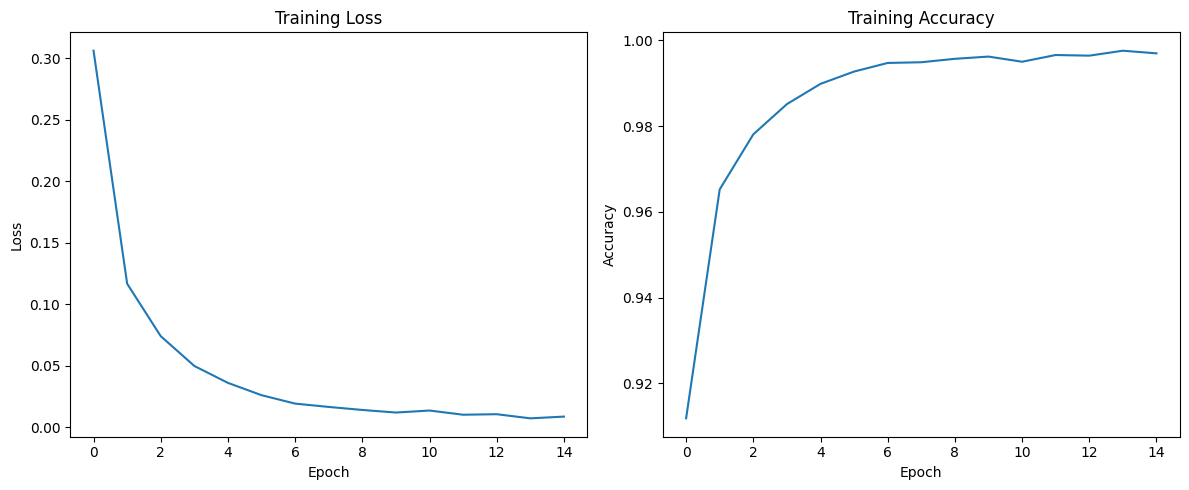

In [10]:
# Modified network architecture for 28x28 images
dense1 = Layer_Dense(784, 256)  # Input: 784 (28x28), First hidden layer: 256 neurons
activation1 = Activation_ReLU()

dense2 = Layer_Dense(256, 128)   # Second hidden layer: 128 neurons
activation2 = Activation_ReLU()

dense3 = Layer_Dense(128, 10)    # Output layer: 10 neurons (for 0-9 digits)
activation3 = Activation_Softmax()

# Loss function and optimizer
loss_function = Loss_crossentropy()
optimizer = Optimizer_Adam(learning_rate=0.001)  # Reduced learning rate

# Training parameters
epochs = 15
loss_history = []
accuracy_history = []

# Load and prepare MNIST dataset (replace with your custom dataset loader)
from tensorflow.keras.datasets import mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# Preprocess data
X_train = X_train.reshape(-1, 28*28).astype('float32') / 255.0
X_test = X_test.reshape(-1, 28*28).astype('float32') / 255.0

# Training loop with batch processing
batch_size = 128
steps = len(X_train) // batch_size

for epoch in range(epochs):
    epoch_loss = 0
    epoch_accuracy = 0

    for step in range(steps):
        # Create batch
        batch_X = X_train[step*batch_size:(step+1)*batch_size]
        batch_y = y_train[step*batch_size:(step+1)*batch_size]

        # Forward pass
        dense1.forward(batch_X)
        activation1.forward(dense1.output)

        dense2.forward(activation1.output)
        activation2.forward(dense2.output)

        dense3.forward(activation2.output)
        activation3.forward(dense3.output)

        # Compute loss
        loss = loss_function.calculate(activation3.output, batch_y)
        epoch_loss += loss

        # Calculate accuracy
        predictions = np.argmax(activation3.output, axis=1)
        accuracy = np.mean(predictions == batch_y)
        epoch_accuracy += accuracy

        # Backward pass
        loss_function.backward(activation3.output, batch_y)
        activation3.backward(loss_function.dinputs)
        dense3.backward(activation3.dinputs)
        activation2.backward(dense3.dinputs)
        dense2.backward(activation2.dinputs)
        activation1.backward(dense2.dinputs)
        dense1.backward(activation1.dinputs)

        # Update weights
        optimizer.update_params(dense1)
        optimizer.update_params(dense2)
        optimizer.update_params(dense3)
        optimizer.post_update_params()

    # Store epoch metrics
    loss_history.append(epoch_loss / steps)
    accuracy_history.append(epoch_accuracy / steps)

    print(f"Epoch: {epoch}, Loss: {loss_history[-1]:.3f}, Accuracy: {accuracy_history[-1]:.3f}")

# Plot training progress
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(loss_history)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.subplot(1, 2, 2)
plt.plot(accuracy_history)
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.tight_layout()
plt.show()

In [11]:
# import os
# import numpy as np
# from PIL import Image

# def load_and_preprocess_images(root_folder, target_size=(28, 28)):
#     images = []
#     labels = []
#     label_map = {}
#     current_label = 0

#     for subdir in os.listdir(root_folder):
#         subdir_path = os.path.join(root_folder, subdir)
#         if os.path.isdir(subdir_path):
#             if subdir not in label_map:
#                 label_map[subdir] = current_label
#                 current_label += 1
#             for filename in os.listdir(subdir_path):
#                 if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
#                     img_path = os.path.join(subdir_path, filename)
#                     img = Image.open(img_path).convert('L')
#                     img = img.resize(target_size)
#                     img_array = np.array(img) / 255.0
#                     img_array = img_array.flatten()
#                     images.append(img_array)
#                     labels.append(label_map[subdir])

#     reverse_label_map = {v: k for k, v in label_map.items()}
#     return np.array(images), np.array(labels), label_map, reverse_label_map

# # Example usage
# X, y, label_map, reverse_label_map = load_and_preprocess_images('/content/extracted_dataset/extracted_images')

In [12]:
# def recognize_symbol(image_path, model_layers, reverse_label_map, target_size=(28, 28)):
#     # Load and preprocess the new image
#     img = Image.open(image_path).convert('L')  # Convert to grayscale
#     img = img.resize(target_size)
#     img_array = np.array(img) / 255.0
#     img_array = img_array.flatten().reshape(1, -1)  # Add batch dimension

#     # Unpack model layers
#     dense1, activation1, dense2, activation2, dense3, activation3 = model_layers

#     # Forward pass
#     dense1.forward(img_array)
#     activation1.forward(dense1.output)
#     dense2.forward(activation1.output)
#     activation2.forward(dense2.output)
#     dense3.forward(activation2.output)
#     activation3.forward(dense3.output)

#     # Get prediction
#     prediction = np.argmax(activation3.output, axis=1)[0]
#     confidence = np.max(activation3.output)
#     symbol = reverse_label_map[prediction]

#     # Display results
#     plt.imshow(img, cmap='gray')
#     plt.title(f"Predicted: {symbol} ({confidence:.2%})")
#     plt.axis('off')
#     plt.show()

#     return symbol, confidence

# # After training, package your model layers
# trained_model = (dense1, activation1, dense2, activation2, dense3, activation3)

# # Example usage
# image_path = "/content/extracted_dataset/extracted_images/0/0_100070.jpg"  # Your image path
# symbol, confidence = recognize_symbol(image_path, trained_model, reverse_label_map)
# print(f"Recognized symbol: {symbol} with {confidence:.2%} confidence")

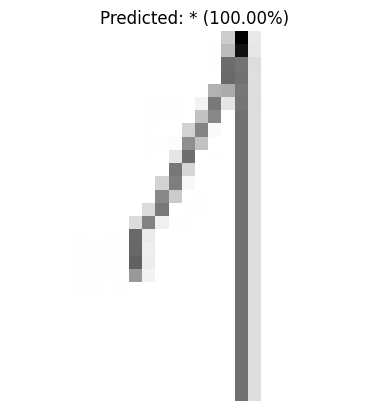

Recognized symbol: * with 100.00% confidence

Final Test Accuracy: 97.93%


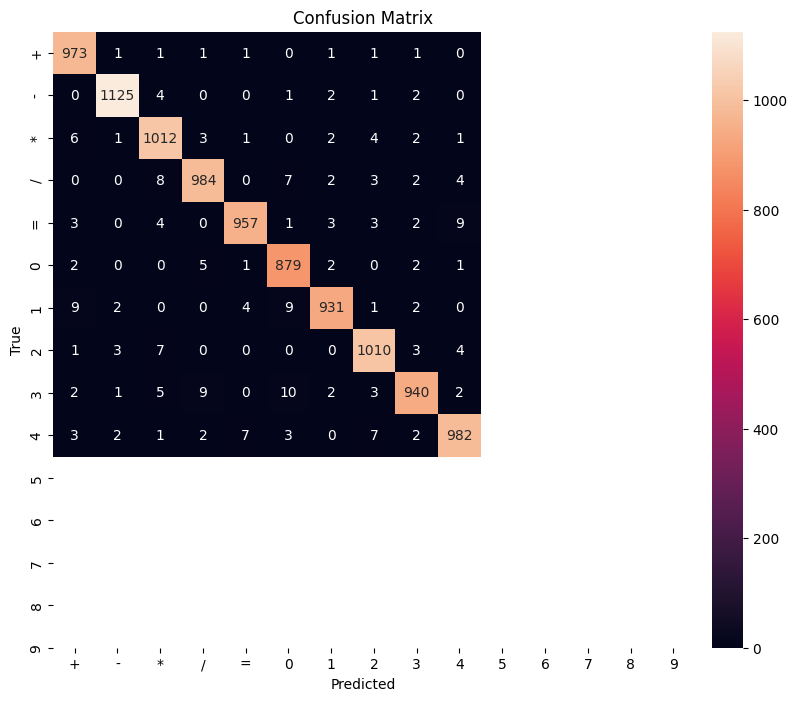

In [19]:
# Add these imports at the top
from PIL import Image
import matplotlib.pyplot as plt

# 1. Prediction Function
def recognize_symbol(image_path, model_layers, reverse_label_map, target_size=(28,28)):
    """
    Recognizes handwritten symbols from new images
    model_layers: tuple containing (dense1, activation1, dense2, activation2, dense3, activation3)
    reverse_label_map: dictionary mapping numeric labels to symbol names
    """
    # Load and preprocess image
    img = Image.open(image_path).convert('L')  # Convert to grayscale
    img = img.resize(target_size)
    img_array = np.array(img) / 255.0
    img_array = img_array.flatten().reshape(1, -1)  # Add batch dimension

    # Unpack model layers
    dense1, activation1, dense2, activation2, dense3, activation3 = model_layers

    # Forward pass
    dense1.forward(img_array)
    activation1.forward(dense1.output)
    dense2.forward(activation1.output)
    activation2.forward(dense2.output)
    dense3.forward(activation2.output)
    activation3.forward(dense3.output)

    # Get prediction
    prediction = np.argmax(activation3.output, axis=1)[0]
    confidence = np.max(activation3.output)
    symbol = reverse_label_map[prediction]

    # Display results
    plt.imshow(img, cmap='gray')
    plt.title(f"Predicted: {symbol} ({confidence:.2%})")
    plt.axis('off')
    plt.show()

    return symbol, confidence

# 2. Save/Load Model Functionality
import pickle

def save_model(model, label_map, filename='symbol_model.pkl'):
    """Saves model layers and label mapping"""
    with open(filename, 'wb') as f:
        pickle.dump({
            'layers': model,
            'label_map': label_map
        }, f)
    print(f"Model saved to {filename}")

def load_model(filename='symbol_model.pkl'):
    """Loads model and label mapping"""
    with open(filename, 'rb') as f:
        data = pickle.load(f)
    print(f"Model loaded from {filename}")
    return data['layers'], data['label_map']

# 3. After Training (Add this at the end)
# Package the trained model
trained_model = (dense1, activation1, dense2, activation2, dense3, activation3)
# Define label map: map symbol to class index
label_map = {
    '+': 0, '-': 1, '*': 2, '/': 3, '=': 4,
    '0': 5, '1': 6, '2': 7, '3': 8, '4': 9,
    '5': 10, '6': 11, '7': 12, '8': 13, '9': 14
}

# Reverse label map: map class index to symbol
reverse_label_map = {v: k for k, v in label_map.items()}

# Example Usage:
# Load test image (replace with your image path)
test_image_path = "/content/extracted_dataset/extracted_images/1/1_100006.jpg"
symbol, confidence = recognize_symbol(test_image_path, trained_model, reverse_label_map)
print(f"Recognized symbol: {symbol} with {confidence:.2%} confidence")

# 4. Evaluation on Test Set (Add before plotting)
dense1.forward(X_test)
activation1.forward(dense1.output)
dense2.forward(activation1.output)
activation2.forward(dense2.output)
dense3.forward(activation2.output)
activation3.forward(dense3.output)

test_predictions = np.argmax(activation3.output, axis=1)
test_accuracy = np.mean(test_predictions == y_test)
print(f"\nFinal Test Accuracy: {test_accuracy:.2%}")

# 5. Confusion Matrix Visualization (Add after evaluation)
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_test, test_predictions)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=[reverse_label_map[i] for i in sorted(reverse_label_map)],
            yticklabels=[reverse_label_map[i] for i in sorted(reverse_label_map)])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

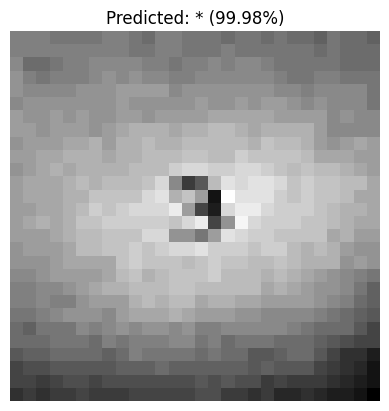

Recognized symbol: * with 99.98% confidence


In [22]:
from PIL import Image
import matplotlib.pyplot as plt

# Package your model layers (after training)
trained_model = (dense1, activation1, dense2, activation2, dense3, activation3)

# Example: predict on a new image
image_path = "/content/3img.jpg"
symbol, confidence = recognize_symbol(image_path, trained_model, reverse_label_map)
print(f"Recognized symbol: {symbol} with {confidence:.2%} confidence")